In [1]:
import os
import glob
import shutil
import json
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import keras

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [2]:
# Defining the working directories
work_dir = 'datasets/cassava-leaf-disease-classification/'
os.listdir(work_dir) 

['label_num_to_disease_map.json',
 'sample_submission.csv',
 'test_images',
 'test_tfrecords',
 'train.csv',
 'train_images',
 'train_tfrecords']

In [22]:
# import train lable and image
labels = pd.read_csv(os.path.join(work_dir, "train.csv"))
print(Counter(labels['label']))

Counter({3: 13158, 4: 2577, 2: 2386, 1: 2189, 0: 1087})


In [4]:
# seperate train(90%)  and test(10%) dataset
train_data, test_data = train_test_split(labels, test_size=0.1, random_state=66)

C:\Users\86188\AppData\Local\Temp\ipykernel_13948\2621277750.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=labels, edgecolor='black', palette=palette)


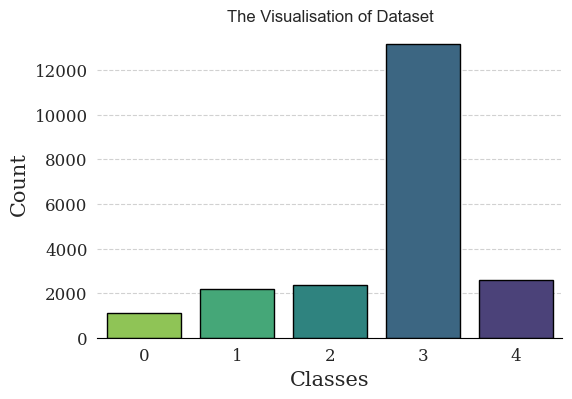

In [21]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(6, 4))

for i in ['top', 'right', 'left']:
    ax.spines[i].set_visible(False)
ax.spines['bottom'].set_color('black')

# Ensure the palette matches the number of unique labels
n_colors = train_data['label'].nunique()
palette = list(reversed(sns.color_palette("viridis", n_colors)))

sns.countplot(x='label', data=labels, edgecolor='black', palette=palette)
plt.xlabel('Classes', fontfamily='serif', size=15)
plt.ylabel('Count', fontfamily='serif', size=15)
plt.xticks(fontfamily='serif', size=12)
plt.yticks(fontfamily='serif', size=12)
ax.grid(axis='y', linestyle='--', alpha=0.9)
plt.title("The Visualisation of Dataset")
plt.savefig("results/dataset_view.png")

plt.show()

In [6]:
# Main parameters
BATCH_SIZE = 8
STEPS_PER_EPOCH = len(train_data)*0.8 // BATCH_SIZE
VALIDATION_STEPS = len(train_data)*0.2 //BATCH_SIZE
EPOCHS = 8
TARGET_SIZE = 512

In [7]:
train_data.label = train_data.label.astype('str')

train_datagen = ImageDataGenerator(validation_split = 0.2,
                                     preprocessing_function = None,
                                     rotation_range = 45,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     fill_mode = 'nearest',
                                     height_shift_range = 0.1,
                                     width_shift_range = 0.1)

train_generator = train_datagen.flow_from_dataframe(train_data,
                         directory = os.path.join(work_dir, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "categorical")


validation_datagen = ImageDataGenerator(validation_split = 0.2)

validation_generator = validation_datagen.flow_from_dataframe(train_data,
                         directory = os.path.join(work_dir, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "categorical")



Found 15406 validated image filenames belonging to 5 classes.
Found 3851 validated image filenames belonging to 5 classes.


In [8]:
test_data.label = test_data.label.astype('str')

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=os.path.join(work_dir, "train_images"),
    x_col="image_id",
    y_col="label",
    target_size=(TARGET_SIZE, TARGET_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical', 
    shuffle=False  
)

Found 2140 validated image filenames belonging to 5 classes.


Found 1 validated image filenames belonging to 1 classes.


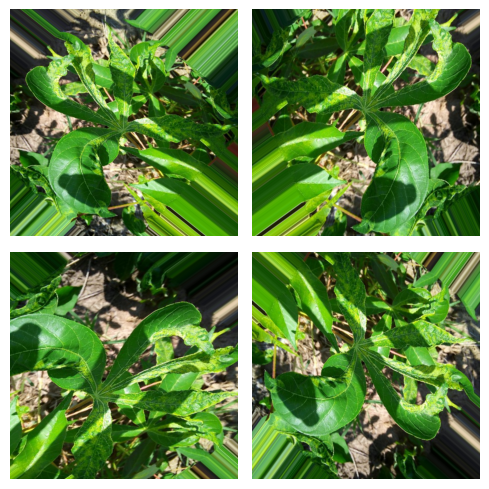

In [9]:
generator = train_datagen.flow_from_dataframe(train_data.iloc[10:11],
                         directory = os.path.join(work_dir, "train_images"),
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = 'categorical')

aug_images = [generator[0][0][0]/255 for i in range(4)]
fig, axes = plt.subplots(2, 2, figsize = (5,5))
axes = axes.flatten()
for img, ax in zip(aug_images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.savefig("results/image_after_augmentation.png")
plt.show()

In [10]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3


def create_model():
    
    model = Sequential()
    # initialize the model with input shape
    model.add(EfficientNetB3(input_shape = (TARGET_SIZE, TARGET_SIZE, 3), include_top = False,
                             weights = 'imagenet',
                             drop_connect_rate=0.6))
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation = 'softmax'))
    
    return model

In [11]:
leaf_model = create_model()
leaf_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 16, 16, 1536)      10783535  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                

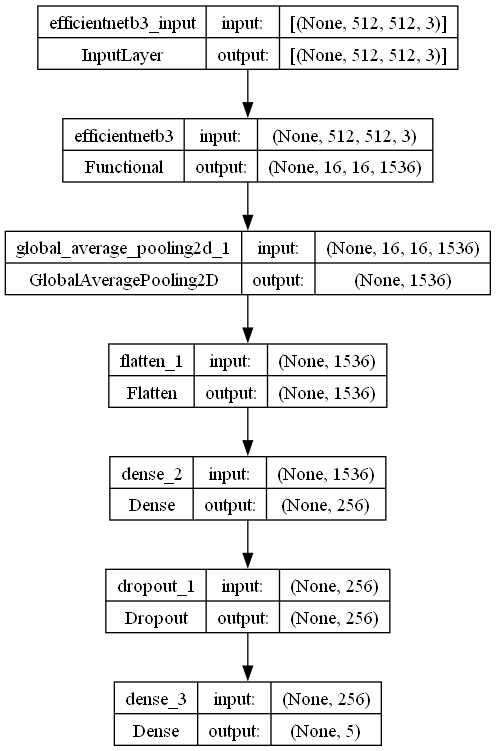

In [28]:
keras.utils.plot_model(leaf_model, to_file='results/model_diagram_512.png', show_shapes=True, show_layer_names=True)

In [13]:

leaf_model = create_model()

'''Compiling the model'''

loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                label_smoothing=0.0001,
                                                name='categorical_crossentropy' )

leaf_model.compile(optimizer = Adam(learning_rate = 1e-3),
                    loss = loss, #'categorical_crossentropy'
                    metrics = ['categorical_accuracy']) #'acc'

# Stop training when the val_loss has stopped decreasing for 3 epochs.
es = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                    restore_best_weights=True, verbose=1)

# Save the model with the minimum validation loss
checkpoint_cb = ModelCheckpoint("results/TS_512/Cassava_model_512'+'.h5",
                                save_best_only=True,
                                monitor = 'val_loss',
                                mode='min')

# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                factor = 0.2,
                                patience = 2,
                                min_lr = 1e-6,
                                mode = 'min',
                                verbose = 1)

history = leaf_model.fit(train_generator,
                            validation_data = validation_generator,
                            epochs= EPOCHS,
                            batch_size = BATCH_SIZE,
                            #class_weight = d_class_weights,
                            steps_per_epoch = STEPS_PER_EPOCH,
                            validation_steps = VALIDATION_STEPS,
                            callbacks=[es, checkpoint_cb, reduce_lr])

leaf_model.save('results/TS_512/Cassava_model_512'+'.h5')  

    

Epoch 1/8


1925/1925 [==============================] - ETA: 0s - loss: 0.8332 - categorical_accuracy: 0.7142

c:\Users\86188\.conda\envs\alms\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1925/1925 [==============================] - 14744s 8s/step - loss: 0.8332 - categorical_accuracy: 0.7142 - val_loss: 0.7832 - val_categorical_accuracy: 0.7165 - lr: 0.0010
Epoch 2/8
1925/1925 [==============================] - 20541s 11s/step - loss: 0.6465 - categorical_accuracy: 0.7789 - val_loss: 0.4966 - val_categorical_accuracy: 0.8404 - lr: 0.0010
Epoch 3/8
1925/1925 [==============================] - 14309s 7s/step - loss: 0.5942 - categorical_accuracy: 0.8010 - val_loss: 0.6214 - val_categorical_accuracy: 0.8199 - lr: 0.0010
Epoch 4/8
1925/1925 [==============================] - 14139s 7s/step - loss: 0.5581 - categorical_accuracy: 0.8138 - val_loss: 0.4725 - val_categorical_accuracy: 0.8459 - lr: 0.0010
Epoch 5/8
1925/1925 [==============================] - 14122s 7s/step - loss: 0.5315 - categorical_accuracy: 0.8227 - val_loss: 0.4214 - val_categorical_accuracy: 0.8617 - lr: 0.0010
Epoch 6/8
1925/1925 [==============================] - 14760s 8s/step - loss: 0.5050 - categor

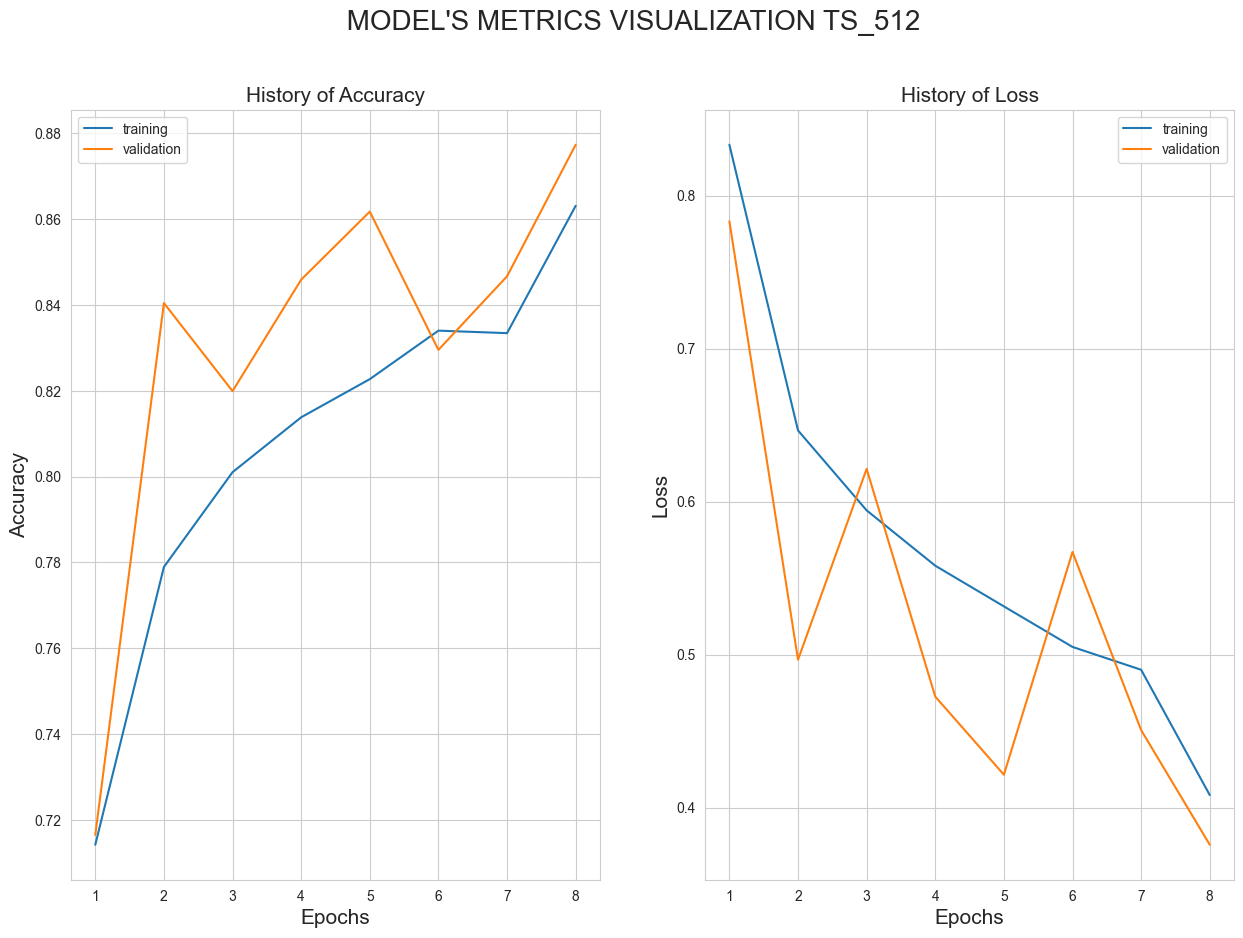

In [19]:
# PLOTTING Result

def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION TS_512 ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.savefig("results/TS_512/train_val_plot_512.png")
    plt.show()
    

Train_Val_Plot(history.history['categorical_accuracy'],history.history['val_categorical_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [15]:
# CHECKING THE METRICS

print('Train_Cat-Acc: ', max(history.history['categorical_accuracy']))
print('Val_Cat-Acc: ', max(history.history['val_categorical_accuracy']))

Train_Cat-Acc:  0.8630990982055664
Val_Cat-Acc:  0.8773388862609863


In [17]:
# Evluation of model (Only used in the final)

test_loss, test_accuracy = leaf_model.evaluate(test_generator)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

268/268 [==============================] - 474s 2s/step - loss: 0.3696 - categorical_accuracy: 0.8804
Test loss: 0.3696124851703644, Test accuracy: 0.8803738355636597


C:\Users\86188\AppData\Local\Temp\ipykernel_13948\1053809739.py:8: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)


268/268 [==============================] - 477s 2s/step


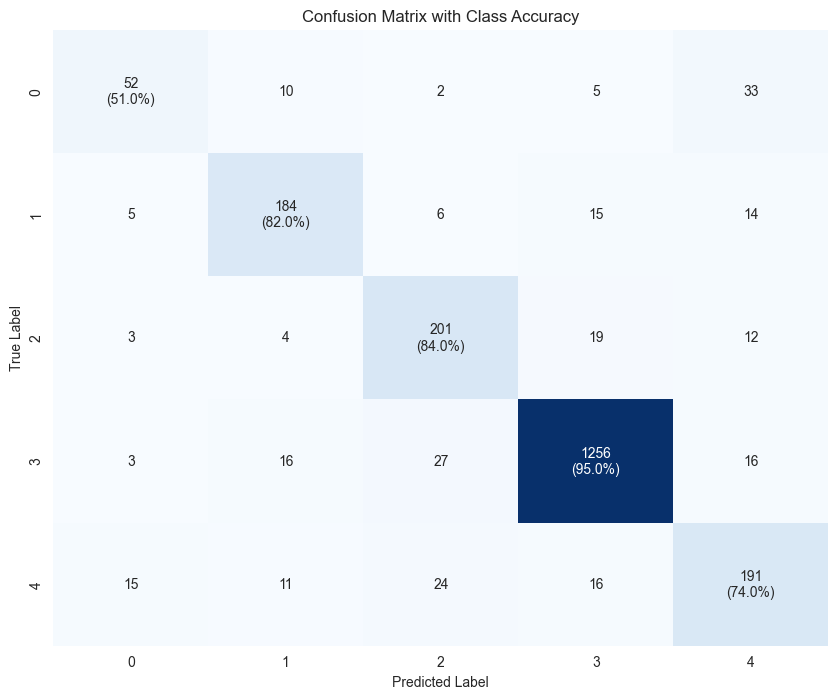

In [31]:
from sklearn.metrics import confusion_matrix


# Predict test set
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = leaf_model.predict(test_generator, steps=test_steps_per_epoch)

predicted_classes = np.argmax(predictions, axis=1)

# get label
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   


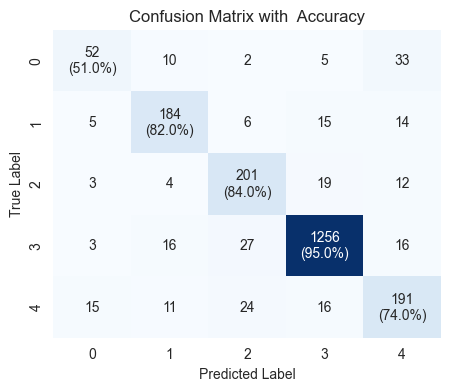

In [34]:
# confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

class_accuracies = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
class_accuracies = np.round(class_accuracies, 2)  


annot = np.empty_like(conf_matrix, dtype=object)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        annot[i, j] = str(conf_matrix[i, j])
    annot[i, i] += "\n(" + str(class_accuracies[i] * 100) + "%)"

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=annot, fmt="", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, cbar=False)

plt.title("Confusion Matrix with  Accuracy")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("results/TS_512/confusion_matrix.png")
plt.show()
